# Analysis and Creation of updating formula for graph edges

## TODOs:
* Implement the get_baseline_metric() function
* Implement the get_counterfactual_metric() functions
* Add more model-related metrics (?)
* Add more model-agnostic metrics (?)

## Install Required Packages

In [ ]:
!pip install numpy
!pip install pandas
!pip install networkx
!pip install scikit-learn
!pip install matplotlib

In [ ]:
!pip install polyjuice_nlp
!pip install torch
!python -m spacy download en_core_web

## Imports

In [13]:
# general imports
import numpy as np
import pandas as pd
import networkx as nx

# Metric-related imports
import torch
from transformers import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from pylev import levenshtein as lev_dist

In [1]:
%run GPT2_functions.ipynb

C:\Users\jimli\anaconda3\envs\nlp_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating updating formula

In [2]:
def update_edges(edges, substitutions, lr, baseline_metric_value, current_metric_value):
    updated_edges = list()
    for (u, v, w) in edges:
        try:
            # get substitution occurences for each edge
            edge_subs = substitutions[(u,v)] 
            # updating formula
            new_w = w + lr * (baseline_metric_value - current_metric_value) / edge_subs
            # add the updated edge to the list
            updated_edges.append((u, v, new_w))
        except KeyError:
            print("Something went wrong during updating of edges' weights")
    
    return updated_edges

## Testing updating formula

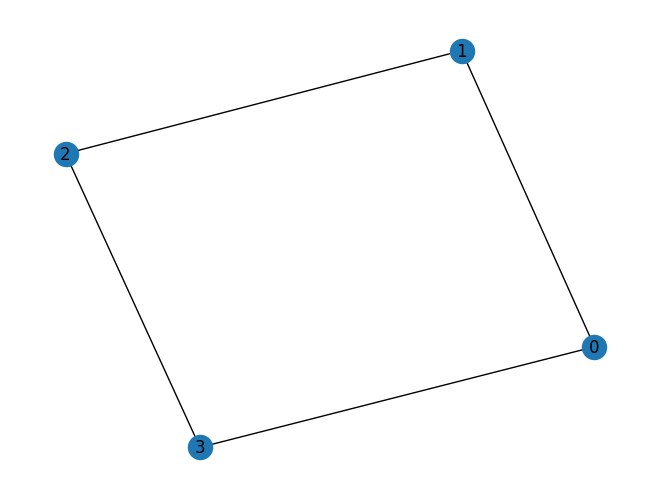

In [5]:
testing_edges = [(0, 1, 2), (1, 2, 2), (2, 3, 2), (3, 0, 2)]

g = nx.Graph()
g.add_weighted_edges_from(testing_edges)
nx.draw(g, with_labels=True)

In [6]:
subs = {(u, v): 1 for (u, v, d) in testing_edges}
new_edges = update_edges(testing_edges, subs, 0.1, 3.0, 2.0)
print(new_edges)

d_w =  0.1 * (3 - 2) / 1

for i in range(len(new_edges)):
    assert round(new_edges[i][2] - testing_edges[i][2], 1) == d_w

print("Assertion test all passed!")

[(0, 1, 2.1), (1, 2, 2.1), (2, 3, 2.1), (3, 0, 2.1)]
Assertion test all passed!


## Creating the complete training process

In [28]:
def generate_model_agnostic_metrics(data, counter_data):
    """
    A function that takes as input the original and the counter data and returns a dictionary with 
    model-agnostic metrics such as closeness and fluency.

    :param data: dataframe containing one column with the original data
    :param counter_data: dataframe containing one column with the counter data
    :returns: dictionary containing model-agnostic metrics
    """
    # extract sentences and counter-sentences from the data and check that they are of the same length
    sentences = [elem[0] for elem in data.values.tolist()]
    counter_sentences= [elem[0] for elem in counter_data.values.tolist()]
    assert len(sentences) == len(counter_sentences)

    # compute average levenshtein distance as a measurement of closeness
    avg_lev = sum(list(map(lambda x: lev_dist(x[0], x[1]), zip(sentences, counter_sentences)))) / len(sentences)

    # compute average fluency
    model, tokenizer = model_init()
    avg_fluency = sum(list(map(lambda x: sent_scoring(model, tokenizer, x)[0], counter_sentences))) / len(sentences)
    # avg_fluency = sum(
    #     list(map(lambda x: abs(sent_scoring(model, tokenizer, x[0])[0] - sent_scoring(model, tokenizer, x[1])[0]), zip(sentences, counter_sentences)))
    # ) / len(sentences)
    
    # create metrics dictionary
    metrics = {
        'levenshtein': avg_lev,
        'fluency': avg_fluency
    }

    return metrics

In [36]:
def generate_model_related_metrics(original_p, counter_p):
    """
    A function that takes as input the original predictions and the new ones, and returns a dictionary with 
    model-related metrics such as flip-rate.

    :param original_p: list containing the predictions for the original data
    :param counter_p: dataframe containing the predictions for the counter data
    :returns: dictionary containing model-related metrics
    """

    # check that predictions and counter_predictions are of the same length
    assert len(original_p) == len(counter_p)
    
    # compute flip_rate
    flip_rate_percent = sum(x[0] != x[1] for x in zip(original_p, counter_p)) / len(original_p)

    # create metrics dictionary
    metrics = {
        'flip-rate': flip_rate_percent
    }

    return metrics

In [ ]:
def get_baseline_metric():
    # TODO: compute baseline metric
    pass

In [ ]:
def get_counterfactual_metric(metrics):
    # TODO: compute the final counterfactual metric as a combination of the metrics given as a dictionary
    pass

In [ ]:
def train_graph(g, data, preprocessor, model, editor, learning_rate=0.01, th=0.005, max_iterations=100, model_required=False):
    """
    A function that represents the training process for the graph edges. It gets predictions for the original data
    then uses a counterfactual editor to generate counter data and get predictions for them. To get the current_metric
    it compares the two predictions and based on those updates the weights of the selected edges.
    
    :param g: the graph used in Maria's framework
    :param data: a dataframe containing the textual examples we will use to train the graph
    :param preprocessor: a custom class that implements the necessary preprocessing of the data
    :param model: a pretrained model on the dataset
    :param editor: the counterfactual editor used to generate counterfactual data
    :param model_required: boolean value for whether or not to compute model-related metrics or
    """

    # generate counter data and compute model_agnostic metrics
    counter_data, selected_edges, substitutions= editor.generate_counterfactuals(g, data)
    baseline_metric = get_baseline_metric()
    current_metrics_dict = generate_model_agnostic_metrics(data, counter_data)

    # if needed, compute model-related metrics as well
    if model_required:
        # first process the original data and get model predictions
        processed_data = preprocessor.process(data)
        original_preds = model.predict(processed_data)
    
        # do the same but for the counterfactual-generated data
        processed_counter_data = preprocessor.process(counter_data)
        counter_preds = model.predict(processed_counter_data)

        # add model-related metrics to the current_metrics dictionary
        current_metrics_dict.update(generate_model_related_metrics(original_preds, counter_preds))

    # compute the final metric as a combination of the previously computed metrics
    current_metric = get_counterfactual_metric(current_metrics_dict)
    
    iterations = 0
    # if metric difference is larger than a threshold and iterations are not at high bound
    while abs(current_metric - baseline_metric) >= th and iterations < max_iterations:
        # remove old values of edges from the graph
        g.remove_edges_from(edges)
        updated_edges = update_edges(edges, substitutions, learning_rate, baseline_metric, current_metric)
        # add the edges with the new edges back into the graph
        g.add_weighted_edges_from(updated_edges)
        
        # change the baseline_metric value
        baseline_metric = max(baseline_metric, current_metric)

        # produce new counter_data and compute current_metric valule
        counter_data, selected_edges, substitutions= editor.generate_counterfactuals(g, data)
        current_metrics_dict = generate_model_agnostic_metrics(data, counter_data)

        # if needed, compute model-related metrics as well
        if model_required:
            processed_counter_data = preprocessor.process(counter_data)
            counter_preds = model.predict(processed_counter_data)
    
            # add model-related metrics to the current_metrics dictionary
            current_metrics_dict.update(generate_model_related_metrics(original_preds, counter_preds))  

        # compute the final metric as a combination of the previously computed metrics
        current_metric = get_counterfactual_metric(current_metrics_dict)
        
        iterations += 1

    return g
    